# Detecting Pneumonia with Convolutional Neural Networks

<img src="https://i.imgur.com/WkFqurM.png" width="700" height="100">

<p style="text-align: center">Normal (left) and abnormal (right) chest radiographs - Increased opacity suggests a pneumonia occurrence</p>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [11]:
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
start_time = datetime.now()

In [12]:
hyper_dimension = 500
hyper_epochs = 5
hyper_batch_size = 16
hyper_feature_maps = 32
hyper_channels = 1
hyper_mode = 'grayscale'

<img src="https://i.imgur.com/TU2LBlg.png" width="900" height="100">

In [13]:
# Initializing the CNN
classifier = Sequential()

# Convolution & pooling - First convolution layer
classifier.add(Conv2D(hyper_feature_maps, (3, 3),
                      input_shape = (hyper_dimension,
                                     hyper_dimension,
                                     hyper_channels),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Convolution & pooling - Second convolution layer (same as first layer)
classifier.add(Conv2D(hyper_feature_maps, (3, 3),
                      input_shape = (hyper_dimension,
                                     hyper_dimension,
                                     hyper_channels),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Convolution & pooling - Third convolution layer
classifier.add(Conv2D(hyper_feature_maps * 2, (3, 3),
                      input_shape = (hyper_dimension,
                                     hyper_dimension,
                                     hyper_channels),
                      activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = hyper_feature_maps * 2, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])


In [14]:
# Creating training and validation image flows

train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               vertical_flip = True)

val_gen = ImageDataGenerator(rescale = 1./255)

train_set = train_gen.flow_from_directory('../input/pneumonia-xray-images/train',
                                          target_size = (hyper_dimension,
                                                         hyper_dimension),
                                          batch_size = hyper_batch_size,
                                          class_mode = 'binary',
                                          color_mode = hyper_mode)

val_set = val_gen.flow_from_directory('../input/pneumonia-xray-images/val',
                                      target_size = (hyper_dimension,
                                                     hyper_dimension),
                                      batch_size = hyper_batch_size,
                                      class_mode = 'binary',
                                      color_mode = hyper_mode)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


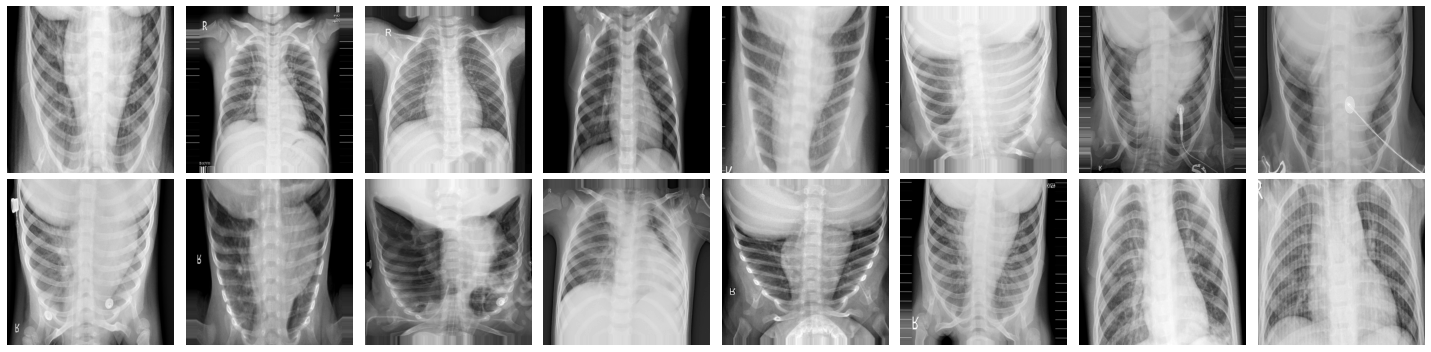

In [15]:
# Visualizing images in the first training set batch 

image_batch = train_set[0][0]

plt.figure(figsize=(20,5))
for i in range(len(image_batch)):
    plt.subplot(2,8,i+1)
    pil_img = array_to_img(image_batch[i])
    plt.imshow(pil_img,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Fitting the model

In [16]:
# Fitting the model

results = classifier.fit_generator(train_set,
                                   steps_per_epoch = len(train_set),
                                   epochs = hyper_epochs,
                                   validation_data = val_set,
                                   validation_steps = len(val_set))

Epoch 1/5
262/262 [==============================] - 202s 769ms/step - loss: 0.3412 - accuracy: 0.8540 - val_loss: 0.1167 - val_accuracy: 0.9385
Epoch 2/5
262/262 [==============================] - 171s 652ms/step - loss: 0.2202 - accuracy: 0.9098 - val_loss: 0.0546 - val_accuracy: 0.9471
Epoch 3/5
262/262 [==============================] - 172s 657ms/step - loss: 0.1933 - accuracy: 0.9272 - val_loss: 0.3005 - val_accuracy: 0.9462
Epoch 4/5
262/262 [==============================] - 173s 660ms/step - loss: 0.1992 - accuracy: 0.9215 - val_loss: 0.0646 - val_accuracy: 0.9433
Epoch 5/5
262/262 [==============================] - 173s 659ms/step - loss: 0.1719 - accuracy: 0.9332 - val_loss: 0.0366 - val_accuracy: 0.9452


In [17]:
# Creating test image flow

test_gen = ImageDataGenerator(rescale = 1./255)

test_set = test_gen.flow_from_directory('../input/pneumonia-xray-images/test',
                                        target_size = (hyper_dimension,
                                                       hyper_dimension),
                                        batch_size = 1,
                                        class_mode = None,
                                        color_mode = hyper_mode,
                                        shuffle=False)

# Making predictions

predictions = classifier.predict_generator(test_set)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Found 624 images belonging to 2 classes.


In [18]:
# Confusion matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
cm

,Predicted Normal,Predicted Pneumonia
Actual Normal,137,97
Actual Pneumonia,2,388
